In [1]:
#set up some colors to use later

full_colors = ['black', 'grey', 'lightgrey', 'brown', \
          'red', 'maroon', 'sienna', 'peru', 'darkorange', 'gold', 'yellow', 'yellowgreen',\
         'lawngreen', 'palegreen', 'turquoise', 'lightseagreen', 'aqua', 'deepskyblue', 'navy',\
         'pink', 'indigo', 'violet']

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
shapes = ['o', '>']

color_combos = [(color, shape) for shape in shapes for color in colors]

In [1]:
#bring in our standard imports 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import time

Zachary Mariani 

6 June 2021 

## Professor Peter Hull's Econometrics Final Project 

While most of my final project's data will be analyzed in R (given the quality of its statistical packages over Python's and the Professor's preference), this notebook will be used for some data visualization. 

### Tax Haven Data

We have four metrics for the "goodness" or quality of tax haven, percent of number of foreign corporations in a country, percent of total assets in a country, percent of total receipts in a country, percent of current earnings and profits less deficit before taxes in a country. We want to visualize how these have changed over time. 

#### Finding Trends 

In [3]:
#import the data from R 
tax_haven_data = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/tax_haven1.csv')

#clean it a bit 

#rename column headers
tax_haven_data = tax_haven_data.rename(\
    columns = \
    {'Year' : 'year',
     'country': 'country_name',
    'Number.of.foreign.corporations': 'n_foreign_corps', 
    'Number.of.US.corporations.returns': 'n_us_corps_returns', 
    'Total.Assets' : 'total_assets', 
    'Total.Receipts': 'total_receipts', 
    'Current.earnings.and.profits..less.deficit..before.taxes' :'curr_EP', 
    'percent_Number.of.foreign.corporations' : 'p_n_foreign_corps', 
    'percent_Total.Assets': 'p_total_assets', 
    'percent_Total.Receipts': 'p_total_receipts', 
    'percent_Current.earnings.and.profits..less.deficit..before.taxes' : 'p_curr_EP'}
)

#drop extra column
tax_haven_data.drop(['Unnamed: 0'], axis = 1, inplace=True)

#sort values by year to make it easier to graph later 
tax_haven_data = tax_haven_data.sort_values('year')

#take a look at the data 
tax_haven_data.head()

#now that we have all of the data much cleaner, let's go ahead and plot it ! 

,country_code,year,country_name,n_foreign_corps,n_us_corps_returns,total_assets,total_receipts,curr_EP,p_n_foreign_corps,p_total_assets,p_total_receipts,p_curr_EP
1328,ALL,1980,all geographic areas,35471.0,4799,508031994.0,699003002.0,47621582.0,1.000000,1.000000,1.000000,1.000000
1352,GBR,1980,united kingdom,5031.0,1557,75916888.0,99112663.0,8033716.0,0.141834,0.149433,0.141791,0.168699
1353,WESTDEU,1980,west germany,2049.0,987,46131107.0,72487510.0,4890880.0,0.057765,0.090804,0.103701,0.102703
1354,OTHER_EUROPE,1980,"other european countries, total",1098.0,424,9509743.0,16050229.0,959001.0,0.030955,0.018719,0.022962,0.020138
1355,AFRICA,1980,"africa, total",1668.0,521,17194842.0,22669414.0,1704355.0,0.047024,0.033846,0.032431,0.035790


In order to get a good starting point, we are going to run a regression for each of the countries for each of the variables of interest. We will store the $\beta$ values and the $R^2$ values, and then take a look. This will tell us how the countries trended over time. 

In [4]:
#storage variables
country_lst = []
country_name_lst = []
var_lst = []
r_2_lst = []
beta_lst = []

vars_of_interest = ['p_n_foreign_corps', 'p_total_assets', 'p_total_receipts', 'p_curr_EP']

for var in vars_of_interest:
    for country in tax_haven_data['country_code'].unique():    
            
        country_spec_data = tax_haven_data.loc[(tax_haven_data['country_code'] == country)]
        
        #get rid of things we're not interested in which could be in the data! 
        country_name = country_spec_data.iloc[0]['country_name']
        
        if 'other' in country_name or 'total' in country_name \
            or 'countries' in country_name or 'west germany' in country_name: 
            continue 
        
        
        x = country_spec_data['year'].values
        y = country_spec_data[var].values
        df_for_regression = pd.DataFrame()
        df_for_regression['x'] = x
        df_for_regression['y'] = y
        try:
            OLS = sm.ols('y ~ x', data=df_for_regression).fit()
            r_2 = OLS.rsquared 
            beta = OLS.params['x']

            
            country_lst.append(country)
            country_name_lst.append(country_name)
            var_lst.append(var)
            r_2_lst.append(r_2)
            beta_lst.append(beta)
        except Exception as e: 
            
            pass
                         
OLS_df = pd.DataFrame(

    {
        'country' : country_lst, 
        'country_name' : country_name_lst,
        'var' : var_lst, 
        'R^2' : r_2_lst, 
        'beta' : beta_lst
    }
)

/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Now that we have gathered all of the data which is relevant, we will pull out the top ten and the bottom ten countries (ranked by $\beta$) and present them below. 

In [5]:
left = OLS_df.loc[OLS_df['var'] == 'p_curr_EP'].sort_values('beta').head(10)
left.reset_index(inplace=True)
left.insert(0, 'Top 10 Worst', 'Top 10 Worst')

right = OLS_df.loc[OLS_df['var'] == 'p_curr_EP'].sort_values('beta').tail(10)
right = right.iloc[::-1]
right.reset_index(inplace=True)
right.insert(0, 'Top 10 Best', 'Top 10 Best')

print('Top 10 Best and Worse Changes in Tax Haven Status as Measured by \n \
     Current Earnings and Profits Locally as a Percentage of Global Total')

p_curr_EP_df_left = left
p_curr_EP_df_right = right 

p_curr_EP_df = pd.concat([left, right], axis = 1)
p_curr_EP_df

Top 10 Best and Worse Changes in Tax Haven Status as Measured by 
      Current Earnings and Profits Locally as a Percentage of Global Total


,Top 10 Worst,index,country,country_name,var,R^2,beta,Top 10 Best,index,country,country_name,var,R^2,beta
0,Top 10 Worst,355,CAN,canada,p_curr_EP,0.744379,-0.003840,Top 10 Best,403,IRL,ireland,p_curr_EP,0.874176,0.004828
1,Top 10 Worst,441,DEU,germany,p_curr_EP,0.845089,-0.003346,Top 10 Best,354,NLD,netherlands,p_curr_EP,0.771189,0.004114
2,Top 10 Worst,365,BEL,belgium,p_curr_EP,0.155277,-0.003200,Top 10 Best,370,LUX,luxembourg,p_curr_EP,0.701945,0.002311
3,Top 10 Worst,343,GBR,united kingdom,p_curr_EP,0.374284,-0.003097,Top 10 Best,391,CYM,cayman islands,p_curr_EP,0.597075,0.001310
4,Top 10 Worst,363,ANT,netherland antilles,p_curr_EP,0.542740,-0.001108,Top 10 Best,385,CHN,china,p_curr_EP,0.896127,0.000712
5,Top 10 Worst,356,BRA,brazil,p_curr_EP,0.593674,-0.001066,Top 10 Best,358,MEX,mexico,p_curr_EP,0.255803,0.000623
6,Top 10 Worst,453,JEY,jersey,p_curr_EP,0.993696,-0.001016,Top 10 Best,387,SGP,singapore,p_curr_EP,0.426242,0.000540
7,Top 10 Worst,368,ITA,italy (including san marino),p_curr_EP,0.596504,-0.000997,Top 10 Best,346,CHE,switzerland,p_curr_EP,0.220039,0.000460
8,Top 10 Worst,361,PAN,panama,p_curr_EP,0.702412,-0.000977,Top 10 Best,362,BMU,bermuda,p_curr_EP,0.005103,0.000414
9,Top 10 Worst,367,FRA,france (including andorra),p_curr_EP,0.400440,-0.000846,Top 10 Best,382,PRI,puerto rico,p_curr_EP,0.544908,0.000296


In [6]:
left = OLS_df.loc[OLS_df['var'] == 'p_total_receipts'].sort_values('beta').head(10)
left.reset_index(inplace=True)
left.insert(0, 'Top 10 Worst', 'Top 10 Worst')

right = OLS_df.loc[OLS_df['var'] == 'p_total_receipts'].sort_values('beta').tail(10)
right = right.iloc[::-1]
right.reset_index(inplace=True)
right.insert(0, 'Top 10 Best', 'Top 10 Best')

print('Top 10 Best and Worse Changes in Tax Haven Status as Measured by \n \
     Total Receipts as a Percentage of Global Total')
p_total_receipts_df_left = left
p_total_receipts_df_right = right

p_total_receipts_df = pd.concat([left, right], axis = 1)
p_total_receipts_df

Top 10 Best and Worse Changes in Tax Haven Status as Measured by 
      Total Receipts as a Percentage of Global Total


,Top 10 Worst,index,country,country_name,var,R^2,beta,Top 10 Best,index,country,country_name,var,R^2,beta
0,Top 10 Worst,320,DEU,germany,p_total_receipts,0.888683,-0.004313,Top 10 Best,282,IRL,ireland,p_total_receipts,0.777695,0.002539
1,Top 10 Worst,244,BEL,belgium,p_total_receipts,0.174413,-0.003553,Top 10 Best,233,NLD,netherlands,p_total_receipts,0.643849,0.002171
2,Top 10 Worst,234,CAN,canada,p_total_receipts,0.541536,-0.001880,Top 10 Best,249,LUX,luxembourg,p_total_receipts,0.625860,0.001655
3,Top 10 Worst,260,VIR,u.s. virgin islands,p_total_receipts,0.277609,-0.001278,Top 10 Best,270,CYM,cayman islands,p_total_receipts,0.844740,0.001462
4,Top 10 Worst,246,FRA,france (including andorra),p_total_receipts,0.273371,-0.000976,Top 10 Best,264,CHN,china,p_total_receipts,0.810647,0.001334
5,Top 10 Worst,222,GBR,united kingdom,p_total_receipts,0.051384,-0.000860,Top 10 Best,241,BMU,bermuda,p_total_receipts,0.404565,0.000955
6,Top 10 Worst,247,ITA,italy (including san marino),p_total_receipts,0.421779,-0.000753,Top 10 Best,266,SGP,singapore,p_total_receipts,0.875668,0.000926
7,Top 10 Worst,240,PAN,panama,p_total_receipts,0.581951,-0.000741,Top 10 Best,237,MEX,mexico,p_total_receipts,0.730413,0.000898
8,Top 10 Worst,281,GRC,greece,p_total_receipts,0.199866,-0.000701,Top 10 Best,225,CHE,switzerland,p_total_receipts,0.410640,0.000632
9,Top 10 Worst,248,BHS,bahamas,p_total_receipts,0.222273,-0.000531,Top 10 Best,263,KOR,south korea,p_total_receipts,0.834941,0.000529


In [7]:
left = OLS_df.loc[OLS_df['var'] == 'p_n_foreign_corps'].sort_values('beta').head(10)
left.reset_index(inplace=True)
left.insert(0, 'Top 10 Worst', 'Top 10 Worst')

right = OLS_df.loc[OLS_df['var'] == 'p_n_foreign_corps'].sort_values('beta').tail(10)
right = right.iloc[::-1]
right.reset_index(inplace=True)
right.insert(0, 'Top 10 Best', 'Top 10 Best')

print('Top 10 Best and Worse Changes in Tax Haven Status as Measured by \n \
     Number of Foreign Corporations Registered as a Percentage of Global Total')

p_n_foreign_corps_df_left = left
p_n_foreign_corps_df_right = right

p_n_foreign_corps_df = pd.concat([left, right], axis = 1)
p_n_foreign_corps_df

Top 10 Best and Worse Changes in Tax Haven Status as Measured by 
      Number of Foreign Corporations Registered as a Percentage of Global Total


,Top 10 Worst,index,country,country_name,var,R^2,beta,Top 10 Best,index,country,country_name,var,R^2,beta
0,Top 10 Worst,99,DEU,germany,p_n_foreign_corps,0.958818,-0.001585,Top 10 Best,43,CHN,china,p_n_foreign_corps,0.804240,0.002408
1,Top 10 Worst,13,CAN,canada,p_n_foreign_corps,0.519157,-0.001088,Top 10 Best,35,IND,india,p_n_foreign_corps,0.819516,0.001127
2,Top 10 Worst,1,GBR,united kingdom,p_n_foreign_corps,0.082671,-0.000894,Top 10 Best,16,MEX,mexico,p_n_foreign_corps,0.648644,0.001125
3,Top 10 Worst,21,ANT,netherland antilles,p_n_foreign_corps,0.601155,-0.000789,Top 10 Best,105,MUS,mauritius,p_n_foreign_corps,0.941466,0.000498
4,Top 10 Worst,20,BMU,bermuda,p_n_foreign_corps,0.673895,-0.000716,Top 10 Best,102,RUS,russia,p_n_foreign_corps,0.696054,0.000486
5,Top 10 Worst,19,PAN,panama,p_n_foreign_corps,0.730222,-0.000570,Top 10 Best,49,CYM,cayman islands,p_n_foreign_corps,0.228806,0.000428
6,Top 10 Worst,2,LBR,liberia,p_n_foreign_corps,0.938189,-0.000543,Top 10 Best,45,SGP,singapore,p_n_foreign_corps,0.861520,0.000423
7,Top 10 Worst,9,AUS,australia,p_n_foreign_corps,0.881841,-0.000521,Top 10 Best,30,ISR,israel,p_n_foreign_corps,0.694394,0.000329
8,Top 10 Worst,60,GRC,greece,p_n_foreign_corps,0.190944,-0.000518,Top 10 Best,100,POL,poland,p_n_foreign_corps,0.520303,0.000315
9,Top 10 Worst,3,ZAF,south africa,p_n_foreign_corps,0.431693,-0.000513,Top 10 Best,92,USSR,union of soviet socialist republics,p_n_foreign_corps,0.959515,0.000290


#### Plotting all visuals

Let us now explore the data visually a bit 

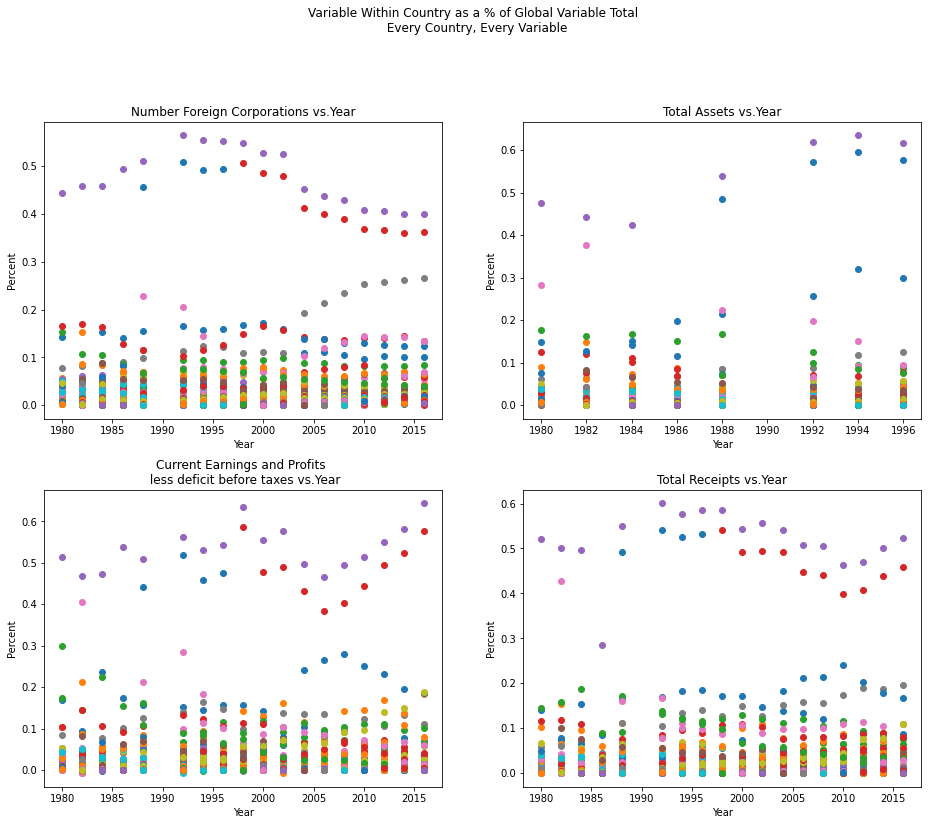

In [8]:
fig, ax = plt.subplots(2,2, figsize = (14,12))
fig.suptitle('Variable Within Country as a % of Global Variable Total \n Every Country, Every Variable')
vars_of_interest = ['p_n_foreign_corps', 'p_total_assets', 'p_total_receipts', 'p_curr_EP']
titles = ['Number Foreign Corporations ', \
          'Total Assets ', 'Total Receipts ', 'Current Earnings and Profits \n less deficit before taxes ']
fig.tight_layout(pad = 5.0)

counter_map = {
    0 : [0,0],
    1 : [0,1],
    2: [1,1],
    3: [1,0]
}

counter = 0
for var in vars_of_interest: 
    for country in tax_haven_data['country_code'].unique(): 
        if country == 'ALL':
            continue
        country_spec = tax_haven_data.loc[(tax_haven_data['country_code'] == country )]
        country_spec.set_index('year', inplace = True)
        country_name = country_spec.iloc[0]['country_name']
        loc0, loc1 = counter_map[counter]
        ax[loc0, loc1].scatter(country_spec.index, country_spec[var], label = country_name)
    ax[loc0, loc1].set_xlabel('Year')
    ax[loc0, loc1].set_ylabel('Percent')
    ax[loc0, loc1].set_title(titles[counter] + 'vs.' + 'Year')
    #ax[loc0, loc1].legend()
    
    counter += 1


A couple of remarks on the graph above. I have excluded legend labels because there are roughly 180 countries plotted which makes a label infeasible. We also see that total assets vs. year will not work well because the data does not exist after 1996. From here, we will now only graph countries who at any point during the entire period have more than 2.5% of the global totals. This will help us eliminate many small countries which are not interesting to the project.

Only Variables with Data for Whole Time Series     
 Only Countries with More than 1% of Global Share at Any Point in Time 

Finished:  p_n_foreign_corps 37 countries plotted
Finished:  p_total_receipts 33 countries plotted
Finished:  p_curr_EP 36 countries plotted


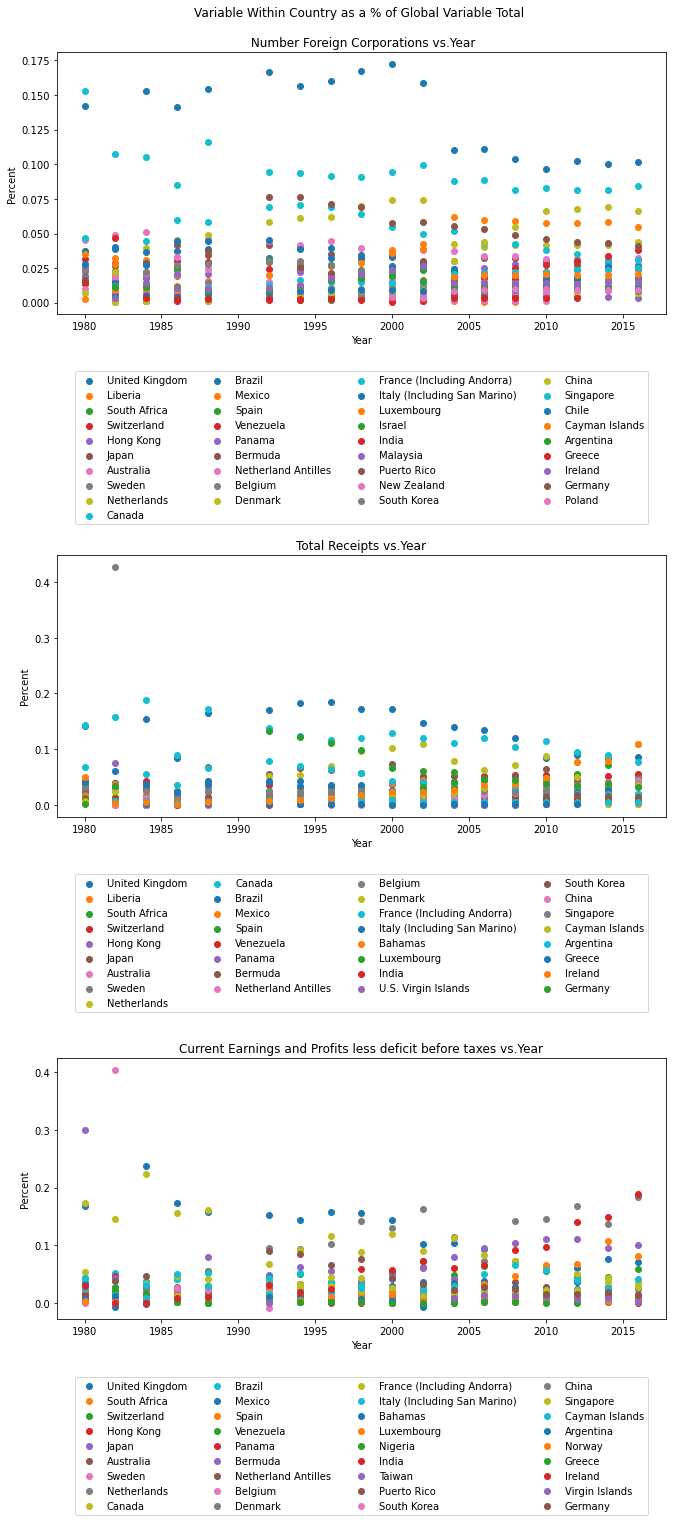

In [9]:
fig, ax = plt.subplots(3, figsize = (15,24))
print('Only Variables with Data for Whole Time Series \
    \n Only Countries with More than 1% of Global Share at Any Point in Time \n')
fig.tight_layout(pad = 22.0)

#we take out total assets vs. year
vars_of_interest = ['p_n_foreign_corps', 'p_total_receipts', 'p_curr_EP']
titles = ['Variable Within Country as a % of Global Variable Total \n \n Number Foreign Corporations ', \
          'Total Receipts ', 'Current Earnings and Profits less deficit before taxes ']

counter = 0
for var in vars_of_interest: 
    c_n = 0
    for country in tax_haven_data['country_code'].unique(): 
        
        #don't plot all since it's just 1 for everything and makes the graph 
        #harder to read 
        if country == 'ALL':
            continue
        
        country_spec = tax_haven_data.loc[(tax_haven_data['country_code'] == country )]
        country_spec.set_index('year', inplace = True)
        
        country_name = country_spec.iloc[0]['country_name']
        #remove regions which aren't super helpful to have in there like 'other east asia'
        if 'other' in country_name or 'total' in country_name \
            or 'countries' in country_name or 'west germany' in country_name: 
            continue 
                
        if country_spec[var].max() < 0.010: 
            continue 
         
        label = country_name.title()
        ax[counter].scatter(country_spec.index, country_spec[var], label = label)
        ax[counter].set_xlabel('Year')
        ax[counter].set_ylabel('Percent')
        ax[counter].set_title(titles[counter] + 'vs.' + 'Year')
        ax[counter].legend(ncol = 4, bbox_to_anchor = (0.5, -0.2), loc = 'upper center')
        c_n += 1
    print('Finished: ', var, c_n, 'countries plotted')
    counter += 1



Above, we see that we still have quite a few countries and the graphs are difficult to parse through. Over time, countries move higher and lower, we are only interested in countries that made large moves positive or lower over the course of time, so we'll filter down to them.

Only Variables with Data for Every Year     
 Only Countries with Differences Between Maxs and Mins of 4%
Finished:  p_n_foreign_corps 7 countries plotted
Finished:  p_total_receipts 15 countries plotted
Finished:  p_curr_EP 16 countries plotted


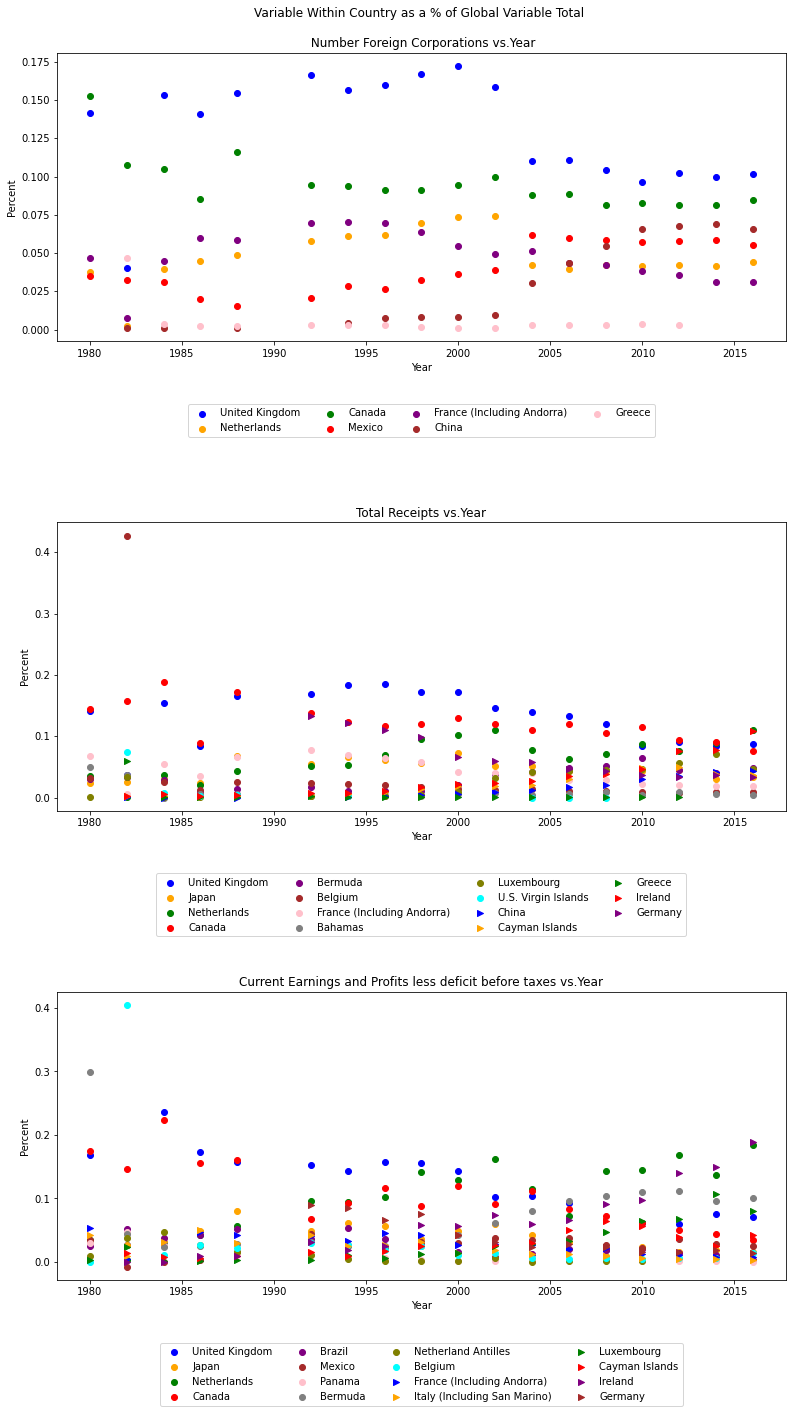

In [10]:
fig, ax = plt.subplots(3, figsize = (15,24))
fig.suptitle('')
fig.tight_layout(pad = 16.0)
print('Only Variables with Data for Every Year \
    \n Only Countries with Differences Between Maxs and Mins of 4%')
#we take out total assets vs. year
vars_of_interest = ['p_n_foreign_corps', 'p_total_receipts', 'p_curr_EP']
titles = ['Variable Within Country as a % of Global Variable Total \n \n Number Foreign Corporations ', 'Total Receipts ', 'Current Earnings and Profits less deficit before taxes ']


counter = 0
for var in vars_of_interest: 
    color_count = 0
    c_n = 0
    for country in tax_haven_data['country_code'].unique(): 
        
        #don't plot all since it's just 1 for everything and makes the graph 
        #harder to read 
        if country == 'ALL':
            continue
        
        country_spec = tax_haven_data.loc[(tax_haven_data['country_code'] == country )]
        country_spec.set_index('year', inplace = True)
        
        country_name = country_spec.iloc[0]['country_name']
        #remove regions which aren't super helpful to have in there like 'other east asia'
        if 'other' in country_name or 'total' in country_name \
            or 'countries' in country_name or 'west germany' in country_name: 
            continue 
        
        #filter down to countries who have made jumps 
                
        if (country_spec[var].max() - country_spec[var].min()) < 0.04: 
            continue 
         
        
        label = country_name.title()
        
        color, marker = color_combos[color_count]
        ax[counter].scatter(country_spec.index, country_spec[var], \
                            label = label, marker = marker, color = color)
#         ax[counter].plot(country_spec[var])
        ax[counter].set_xlabel('Year')
        ax[counter].set_ylabel('Percent')
        ax[counter].set_title(titles[counter] + 'vs.' + 'Year')
        ax[counter].legend(ncol = 4, bbox_to_anchor = (0.5, -0.2), loc = 'upper center')
        c_n += 1
        color_count += 1
    print('Finished: ', var, c_n, 'countries plotted')
    counter += 1




#### Plotting Visuals from Trends

Now, we've generated these graphs above, let's return to the $\beta$ and $R^2$ parameters. 



Only Variables with Data for Every Year     
 Only Countries in Top or Bottom 10 by Beta


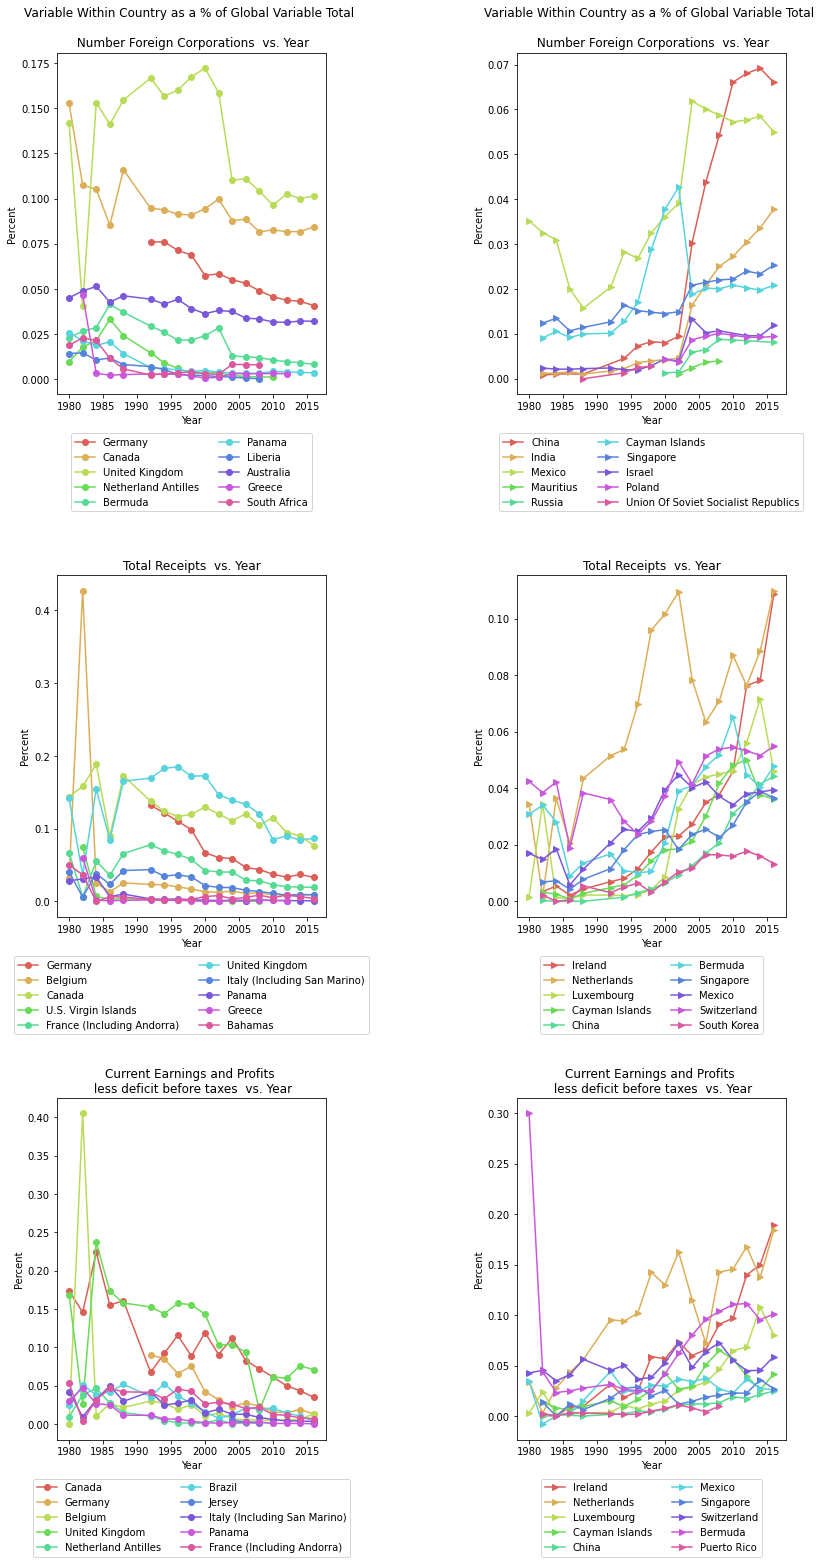

In [54]:
colors = sns.color_palette("hls", 10)

beta_r_tables = [[p_n_foreign_corps_df_left, p_n_foreign_corps_df_right],\
                 [p_total_receipts_df_left, p_total_receipts_df_right], \
                 [p_curr_EP_df_left, p_curr_EP_df_right]]

fig, ax = plt.subplots(3,2, figsize = (15,24))
fig.tight_layout(pad=16)
print('Only Variables with Data for Every Year \
    \n Only Countries in Top or Bottom 10 by Beta')
titles = ['Variable Within Country as a % of Global Variable Total \n \n Number Foreign Corporations ', \
          'Total Receipts ', 'Current Earnings and Profits \n less deficit before taxes ']
cc = 0
for n, var in enumerate(beta_r_tables): 
    
    marker = 'o'
    for nt, table in enumerate(var):
        
        var_of_interest = table.iloc[0]['var']
        
        for country_code in table['country']:
            country_name = country_code_dict[country_code]
            
            try: 
                color = colors[cc]
                cc+=1
            except: 
                cc = 0
                color = colors[cc]
                cc += 1
                
                
            country_spec = tax_haven_data.loc[(tax_haven_data['country_code'] == country_code)]
            ax[n, nt].plot(country_spec['year'], country_spec[var_of_interest], \
                             label = country_name.title(), marker = marker, color = color)

        ax[n, nt].legend(ncol = 2, bbox_to_anchor = (0.5, -0.1), loc = 'upper center')
        ax[n, nt].set_xlabel('Year')
        ax[n, nt].set_ylabel('Percent')
        
        ax[n, nt].set_title(titles[n] + ' vs. Year')
        marker = '>'
    


In [53]:
table

,Top 10 Worst,index,country,country_name,var,R^2,beta
0,Top 10 Worst,99,DEU,germany,p_n_foreign_corps,0.958818,-0.001585
1,Top 10 Worst,13,CAN,canada,p_n_foreign_corps,0.519157,-0.001088
2,Top 10 Worst,1,GBR,united kingdom,p_n_foreign_corps,0.082671,-0.000894
3,Top 10 Worst,21,ANT,netherland antilles,p_n_foreign_corps,0.601155,-0.000789
4,Top 10 Worst,20,BMU,bermuda,p_n_foreign_corps,0.673895,-0.000716
5,Top 10 Worst,19,PAN,panama,p_n_foreign_corps,0.730222,-0.000570
6,Top 10 Worst,2,LBR,liberia,p_n_foreign_corps,0.938189,-0.000543
7,Top 10 Worst,9,AUS,australia,p_n_foreign_corps,0.881841,-0.000521
8,Top 10 Worst,60,GRC,greece,p_n_foreign_corps,0.190944,-0.000518
9,Top 10 Worst,3,ZAF,south africa,p_n_foreign_corps,0.431693,-0.000513


### Cleaning Controls Data

#### Population Data
The issue now is that we've downloaded a good deal of data from different sources, we need to make sure that every country_name variable between all different sources has an easy to access country_code variable that matches our tax_haven_data dataset!

In [12]:
tax_haven_data.head()

,country_code,year,country_name,n_foreign_corps,n_us_corps_returns,total_assets,total_receipts,curr_EP,p_n_foreign_corps,p_total_assets,p_total_receipts,p_curr_EP
1328,ALL,1980,all geographic areas,35471.0,4799,508031994.0,699003002.0,47621582.0,1.000000,1.000000,1.000000,1.000000
1352,GBR,1980,united kingdom,5031.0,1557,75916888.0,99112663.0,8033716.0,0.141834,0.149433,0.141791,0.168699
1353,WESTDEU,1980,west germany,2049.0,987,46131107.0,72487510.0,4890880.0,0.057765,0.090804,0.103701,0.102703
1354,OTHER_EUROPE,1980,"other european countries, total",1098.0,424,9509743.0,16050229.0,959001.0,0.030955,0.018719,0.022962,0.020138
1355,AFRICA,1980,"africa, total",1668.0,521,17194842.0,22669414.0,1704355.0,0.047024,0.033846,0.032431,0.035790


In [13]:
#build the country_code_dict!
country_code_dict = {}
for row in tax_haven_data.iterrows():
    country_code = row[1]['country_code']
    country_name = row[1]['country_name']
    
    if not country_code in country_code_dict.keys():
        country_code_dict[country_code] = country_name

In [14]:
population_data = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/controls data/population.csv')
population_data.drop(['Indicator Name','Indicator Code'], axis = 1, inplace=True)
population_data.rename(columns = {'Country Name' : 'country_name', 
                                 'Country Code': 'country_code',
                                 }, inplace=True)
population_data.head()

,country_name,country_code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,https://data.worldbank.org/indicator/SP.POP.TOTL
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,106314.0,NaN,NaN
1,Afghanistan,AFG,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,10399926.0,...,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,38041754.0,NaN,NaN
2,Angola,AGO,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,5774243.0,...,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,31825295.0,NaN,NaN
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,NaN,NaN
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,77142.0,NaN,NaN


In [15]:
for row in population_data.iterrows(): 
    row = row[1]
    country_name = row['country_name'].lower()
    country_code = row['country_code']
    
    if not country_code in country_code_dict.keys(): 
        #look for suggestions
        suggs = []
        for key, value in country_code_dict.items():
            if country_name in value: 
                suggs.append((key, value))
            
        replace = input('No data found for:' + str(country_code) + str(country_name) \
                           + '\n our suggestions are:' + str(suggs) + \
                          'would you like to replace (n is create new)')
        if replace == 'n':
            country_code_dict[country_code] = country_name 
            print('added', country_code, country_name)
        if replace == 'y': 
            replace = input('What would you like to replace code ' + str(country_code) + ' with ?')
            population_data['country_code'].replace({country_code : replace},inplace=True)
            print('replaced', country_code, replace)
        

No data found for:ABWaruba
 our suggestions are:[]would you like to replace (n is create new)n
added ABW aruba
No data found for:AFGafghanistan
 our suggestions are:[]would you like to replace (n is create new)n
added AFG afghanistan
No data found for:AGOangola
 our suggestions are:[]would you like to replace (n is create new)n
added AGO angola
No data found for:ALBalbania
 our suggestions are:[]would you like to replace (n is create new)n
added ALB albania
No data found for:ANDandorra
 our suggestions are:[('FRA', 'france (including andorra)')]would you like to replace (n is create new)FRA
No data found for:ARBarab world
 our suggestions are:[]would you like to replace (n is create new)ARAB
No data found for:ARMarmenia
 our suggestions are:[]would you like to replace (n is create new)n
added ARM armenia
No data found for:ATGantigua and barbuda
 our suggestions are:[]would you like to replace (n is create new)n
added ATG antigua and barbuda
No data found for:AZEazerbaijan
 our suggesti

added ISL iceland
No data found for:JORjordan
 our suggestions are:[]would you like to replace (n is create new)n
added JOR jordan
No data found for:KGZkyrgyz republic
 our suggestions are:[]would you like to replace (n is create new)n
added KGZ kyrgyz republic
No data found for:KHMcambodia
 our suggestions are:[]would you like to replace (n is create new)n
added KHM cambodia
No data found for:KIRkiribati
 our suggestions are:[]would you like to replace (n is create new)n
added KIR kiribati
No data found for:KNAst. kitts and nevis
 our suggestions are:[]would you like to replace (n is create new)n
added KNA st. kitts and nevis
No data found for:LAClatin america & caribbean (excluding high income)
 our suggestions are:[]would you like to replace (n is create new)n
added LAC latin america & caribbean (excluding high income)
No data found for:LAOlao pdr
 our suggestions are:[]would you like to replace (n is create new)n
added LAO lao pdr
No data found for:LCAst. lucia
 our suggestions are

No data found for:STPsao tome and principe
 our suggestions are:[]would you like to replace (n is create new)n
added STP sao tome and principe
No data found for:SURsuriname
 our suggestions are:[]would you like to replace (n is create new)n
added SUR suriname
No data found for:SWZeswatini
 our suggestions are:[]would you like to replace (n is create new)n
added SWZ eswatini
No data found for:SXMsint maarten (dutch part)
 our suggestions are:[]would you like to replace (n is create new)n
added SXM sint maarten (dutch part)
No data found for:SYCseychelles
 our suggestions are:[]would you like to replace (n is create new)n
added SYC seychelles
No data found for:SYRsyrian arab republic
 our suggestions are:[]would you like to replace (n is create new)n
added SYR syrian arab republic
No data found for:TCAturks and caicos islands
 our suggestions are:[]would you like to replace (n is create new)n
added TCA turks and caicos islands
No data found for:TCDchad
 our suggestions are:[]would you li

In [16]:
population_data['country_code'].replace({'ABW' : 'all'}, inplace=True)

In [17]:
country_code_dict

{'ALL': 'all geographic areas',
 'GBR': 'united kingdom',
 'WESTDEU': 'west germany',
 'OTHER_EUROPE': 'other european countries, total',
 'AFRICA': 'africa, total',
 'LBR': 'liberia',
 'ZAF': 'south africa',
 'OTHER_AFRICA': 'other african countries',
 'ASIA': 'asia, total',
 'CHE': 'switzerland',
 'HKG': 'hong kong',
 'JPN': 'japan',
 'MIDDLEEAST_EXCEPT_OPEC': 'middle east, except OPEC',
 'PHL': 'philippines',
 'OTHER_ASIA': 'other asia',
 'OCEANIA': 'oceania, total',
 'AUS': 'australia',
 'OTHER_OCEANIA': 'other countries of oceania',
 'OPEC': 'opec countries (included above)',
 'IDN': 'indonesia',
 'SWE': 'sweden',
 'TOTAL_USPOSSESSIONS': 'puerto rico and u.s. possessions, total',
 'NLD': 'netherlands',
 'CAN': 'canada',
 'LATAM': 'latin america, total',
 'BRA': 'brazil',
 'ECU': 'ecuador',
 'MEX': 'mexico',
 'ESP': 'spain',
 'VEN': 'venezuela',
 'OTHER_LATAM': 'other latin america',
 'OTHER_WESTERNHEMISPHERE': 'other western hemisphere, total',
 'PAN': 'panama',
 'BMU': 'bermuda',

#### Real GDP per Cap

In [18]:
real_GDP = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/controls data/real_GDP_per_cap.csv')

In [19]:
real_GDP.rename(columns = {
    'Entity' : 'country_name', 
    'Code': 'country_code',
    'Year' : 'year',
    'real_GDP_per_cap' : 'Output-side real GDP per capita (gdppc_o) (PWT 9.1 (2019))'
}, inplace = True)
real_GDP.head()

,country_name,country_code,year,Output-side real GDP per capita (gdppc_o) (PWT 9.1 (2019)),https://ourworldindata.org/grapher/real-gdp-per-capita-pennwt
0,Albania,ALB,1970,2828.0728,NaN
1,Albania,ALB,1971,2869.7212,NaN
2,Albania,ALB,1972,2919.5935,NaN
3,Albania,ALB,1973,2968.1025,NaN
4,Albania,ALB,1974,3024.6765,NaN


In [20]:
country_names = real_GDP['country_name'].unique()
for n, country_code in enumerate(real_GDP['country_code'].unique()): 
    time_0 = time.time()
    country_code = country_code
    country_name = country_names[n].lower()
    
    if not country_code in country_code_dict.keys(): 
        #look for suggestions
        suggs = []
        for key, value in country_code_dict.items():
            if country_name in value: 
                suggs.append((key, value))
            
        replace = input('No data found for: ' + str(country_code) +' ' + str(country_name) \
                           + '\n our suggestions are: ' + str(suggs) + \
                          ' type code to replace or , c(create)')
        
        if replace == 'c':
            country_code_dict[country_code] = country_name 
            print('added', country_code, country_name)
            
        if replace != 'c' and replace != '': 
            real_GDP['country_code'].replace({country_code : replace},inplace=True)
            print('replaced', country_code, replace)
            
    print('finished checking', country_code, time.time() - time_0)

finished checking ALB 5.0067901611328125e-06
finished checking DZA 4.0531158447265625e-06
finished checking AGO 2.1457672119140625e-06
No data found for: AIA anguilla
 our suggestions are: [] type code to replace or , c(create)n
replaced AIA n
finished checking AIA 4.928341627120972
finished checking ATG 7.3909759521484375e-06
finished checking ARG 3.0994415283203125e-06
finished checking ARM 3.0994415283203125e-06
finished checking ABW 2.86102294921875e-06
finished checking AUS 1.9073486328125e-06
finished checking AUT 5.245208740234375e-06
finished checking AZE 4.0531158447265625e-06
finished checking BHS 1.9073486328125e-06
finished checking BHR 2.1457672119140625e-06
finished checking BGD 1.9073486328125e-06
finished checking BRB 5.0067901611328125e-06
finished checking BLR 3.0994415283203125e-06
finished checking BEL 2.1457672119140625e-06
finished checking BLZ 3.0994415283203125e-06
finished checking BEN 6.9141387939453125e-06
finished checking BMU 4.0531158447265625e-06
finished

### Cleaning Outcomes Data

#### Life Expectancy at Birth

In [21]:
life_expectancy = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/outcomes data/life_expectancy_at_birth.csv')
life_expectancy.rename\
    (columns = {'Entity': 'country_name', 'Code':'country_code', 'Year' : 'year'}, inplace=True)
life_expectancy.head()

,country_name,country_code,year,"Life expectancy at birth, total (years)",https://ourworldindata.org/grapher/life-expectancy-at-birth-total-years
0,Afghanistan,AFG,1960,32.292,NaN
1,Afghanistan,AFG,1961,32.742,NaN
2,Afghanistan,AFG,1962,33.185,NaN
3,Afghanistan,AFG,1963,33.624,NaN
4,Afghanistan,AFG,1964,34.060,NaN


In [22]:
for n, country_code in enumerate(life_expectancy['country_code'].unique()): 
    
    try: 
        
        country_code = country_code
        country_name = life_expectancy.loc\
            [(life_expectancy['country_code'] == country_code)].iloc[0]['country_name'].lower()

        if not country_code in country_code_dict.keys(): 
            #look for suggestions
            suggs = []
            for key, value in country_code_dict.items():
                if country_name in value: 
                    suggs.append((key, value))

            replace = input('No data found for: ' + str(country_code) +' ' + str(country_name) \
                               + '\n our suggestions are: ' + str(suggs) + \
                              ' type code to replace or , c(create)')

            if replace == 'c':
                country_code_dict[country_code] = country_name 
                print('added', country_code, country_name)

            if replace != 'c' and replace != '': 
                life_expectancy['country_code'].replace({country_code : replace},inplace=True)
                print('replaced', country_code, replace)
            
    except: 
        print('Failed on', country_code, country_name)

Failed on nan antigua and barbuda
No data found for: OWID_CIS channel islands
 our suggestions are: [('CHI', 'channel islands')] type code to replace or , c(create)CHI
replaced OWID_CIS CHI
-3.8351078033447266
No data found for: OWID_KOS kosovo
 our suggestions are: [('XKX', 'kosovo')] type code to replace or , c(create)XKX
replaced OWID_KOS XKX
-3.7942190170288086
No data found for: WSM samoa
 our suggestions are: [('ASM', 'american samoa')] type code to replace or , c(create)ASM
replaced WSM ASM
-2.949007749557495
No data found for: SMR san marino
 our suggestions are: [('ITA', 'italy (including san marino)')] type code to replace or , c(create)ITA
replaced SMR ITA
-1.9661691188812256
No data found for: OWID_WRL world
 our suggestions are: [('WLD', 'world')] type code to replace or , c(create)c
added OWID_WRL world
-8.1234130859375


In [23]:
life_expectancy.loc[(life_expectancy['country_code'] == 'FRA')].iloc[0]['country_name']
life_expectancy.head()

,country_name,country_code,year,"Life expectancy at birth, total (years)",https://ourworldindata.org/grapher/life-expectancy-at-birth-total-years
0,Afghanistan,AFG,1960,32.292,NaN
1,Afghanistan,AFG,1961,32.742,NaN
2,Afghanistan,AFG,1962,33.185,NaN
3,Afghanistan,AFG,1963,33.624,NaN
4,Afghanistan,AFG,1964,34.060,NaN


In [34]:
pd.DataFrame.from_dict(country_code_dict, orient = 'index')\
    .to_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/country_code_dict')

#### Homicides

In [38]:
homicides = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/outcomes data/homicides.csv')
homicides.rename(columns = {'Entity': 'country_name', \
                            'Code':'country_code', 'Year' : 'year',\
                           'Homicide Rate (Clio Infra)': 'homicide_rate'}, inplace=True)
homicides.head()

,country_name,country_code,year,homicide_rate,https://ourworldindata.org/homicides
0,Afghanistan,AFG,2004,3.40,NaN
1,Albania,ALB,1987,1.43,NaN
2,Albania,ALB,1988,1.56,NaN
3,Albania,ALB,1989,2.17,NaN
4,Albania,ALB,1992,4.10,NaN


In [40]:
for n, country_code in enumerate(homicides['country_code'].unique()): 
    try: 
        country_code = country_code
        country_name = homicides.loc\
            [(homicides['country_code'] == country_code)].iloc[0]['country_name'].lower()

        if not country_code in country_code_dict.keys(): 
            #look for suggestions
            suggs = []
            for key, value in country_code_dict.items():
                if country_name in value: 
                    suggs.append((key, value))

            replace = input('No data found for: ' + str(country_code) +' ' + str(country_name) \
                               + '\n our suggestions are: ' + str(suggs) + \
                              ' type code to replace or , c(create)')

            if replace == 'c':
                country_code_dict[country_code] = country_name 
                print('added', country_code, country_name)

            if replace != 'c' and replace != '': 
                homicides['country_code'].replace({country_code : replace},inplace=True)
                print('replaced', country_code, replace)
    except: 
        print('Failed on', country_code, country_name)

No data found for: GUF french guiana
 our suggestions are: [] type code to replace or , c(create)c
added GUF french guiana
No data found for: GLP guadeloupe
 our suggestions are: [] type code to replace or , c(create)c
added GLP guadeloupe
No data found for: MTQ martinique
 our suggestions are: [] type code to replace or , c(create)c
added MTQ martinique
No data found for: SMR san marino
 our suggestions are: [('ITA', 'italy (including san marino)')] type code to replace or , c(create)ITA
replaced SMR ITA


#### Deaths by Age

In [43]:
def clean_OWID(data):
    data.rename(columns = {'Entity': 'country_name', \
                            'Code':'country_code', 'Year' : 'year'}, inplace=True)
    for n, country_code in enumerate(data['country_code'].unique()): 
        try: 
            country_code = country_code
            country_name = data.loc\
                [(data['country_code'] == country_code)].iloc[0]['country_name'].lower()

            if not country_code in country_code_dict.keys(): 
                #look for suggestions
                suggs = []
                for key, value in country_code_dict.items():
                    if country_name in value: 
                        suggs.append((key, value))

                replace = input('No data found for: ' + str(country_code) +' ' + str(country_name) \
                                   + '\n our suggestions are: ' + str(suggs) + \
                                  ' type code to replace or , c(create)')

                if replace == 'c':
                    country_code_dict[country_code] = country_name 
                    print('added', country_code, country_name)

                if replace != 'c' and replace != '': 
                    data['country_code'].replace({country_code : replace},inplace=True)
                    print('replaced', country_code, replace)
        except: 
            print('Failed on', country_code, country_name)

In [44]:
deaths_by_age = pd.read_csv('/Users/zachmariani/Desktop/Metrics/Final Project/Data/outcomes data/deaths_by_age.csv')
clean_OWID(deaths_by_age)

Failed on nan american samoa
No data found for: AND andorra
 our suggestions are: [('FRA', 'france (including andorra)')] type code to replace or , c(create)FRA
replaced AND FRA
No data found for: WSM samoa
 our suggestions are: [('ASM', 'american samoa')] type code to replace or , c(create)ASM
replaced WSM ASM


#### Central Government Expenditure as a Share of GDP


In [46]:
gov_expend = pd.read_csv("/Users/zachmariani/Desktop/Metrics/Final Project/Data/outcomes data/central_government_expenditure_as_share_of_GDP.csv")

clean_OWID(gov_expend)


Failed on nan cape verde
No data found for: WSM samoa
 our suggestions are: [('ASM', 'american samoa')] type code to replace or , c(create)ASM
replaced WSM ASM
No data found for: SMR san marino
 our suggestions are: [('ITA', 'italy (including san marino)')] type code to replace or , c(create)ITA
replaced SMR ITA


#### HDI


In [49]:
HDI = pd.read_csv("/Users/zachmariani/Desktop/Metrics/Final Project/Data/outcomes data/HDI.csv")
clean_OWID(HDI)

No data found for: AND andorra
 our suggestions are: [('FRA', 'france (including andorra)')] type code to replace or , c(create)FRA
replaced AND FRA
Failed on nan kiribati
No data found for: WSM samoa
 our suggestions are: [('ASM', 'american samoa')] type code to replace or , c(create)c
added WSM samoa


In [51]:
tax_haven_data.loc[(tax_haven_data['country_name'] == 'united kingdom')]

,country_code,year,country_name,n_foreign_corps,n_us_corps_returns,total_assets,total_receipts,curr_EP,p_n_foreign_corps,p_total_assets,p_total_receipts,p_curr_EP
1352,GBR,1980,united kingdom,5031.0,1557,75916888.0,99112663.0,8033716.0,0.141834,0.149433,0.141791,0.168699
1405,GBR,1982,united kingdom,1090.0,358,18394428.0,23646871.0,967456.0,0.040381,0.033012,0.036499,0.026364
1493,GBR,1984,united kingdom,4135.0,634,83826123.0,96419493.0,11507602.0,0.153103,0.140788,0.154387,0.236822
1574,GBR,1986,united kingdom,1058.0,381,146804566.0,97260938.0,9798051.0,0.141067,0.198279,0.084751,0.173139
49,GBR,1988,united kingdom,1159.0,399,205412482.0,135953877.0,12601876.0,0.154533,0.214393,0.165198,0.157896
174,GBR,1992,united kingdom,1250.0,406,388570187.0,207364878.0,10631130.0,0.166667,0.257233,0.169573,0.152717
255,GBR,1994,united kingdom,1175.0,412,631387416.0,246068204.0,14158843.0,0.156667,0.320743,0.182837,0.143850
345,GBR,1996,united kingdom,1200.0,451,799984585.0,310605964.0,22188311.0,0.160000,0.300217,0.185253,0.157352
432,GBR,1998,united kingdom,1255.0,467,NaN,301366290.0,22394670.0,0.167333,NaN,0.172257,0.155691
520,GBR,2000,united kingdom,1291.0,455,NaN,372709148.0,29696179.0,0.172133,NaN,0.172732,0.143062
